In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const
import seaborn as sns

In [2]:
%matplotlib notebook

In [3]:
def Create_dataframes(filenames, directory, row_label):
    dataframes = {}
    for name in filenames:
        file_directory = f'{directory}/{name}.csv'
        data = pd.read_csv(file_directory)
        data.set_index(row_label, inplace=True)
        dataframes[name] = data
    return dataframes

def Ensure_all(All_variables):
    rejected_IDs = []
    num_variables = len(All_variables)
    for variable_table in All_variables:
        Gaia_IDs = variable_table.index
        for ID in Gaia_IDs:
            is_rejected = ID in rejected_IDs
            if is_rejected:
                continue
            try:
                if pd.isna(variable_table.loc[ID]):
                    rejected_IDs.append(ID)
            except:
                rejected_IDs.append(ID)
    return rejected_IDs

def Remove_rejects(All_variables, rejected_IDs):
    for variable_table in All_variables:
            variable_table.drop(rejected_IDs, inplace=True)

<IPython.core.display.Javascript object>


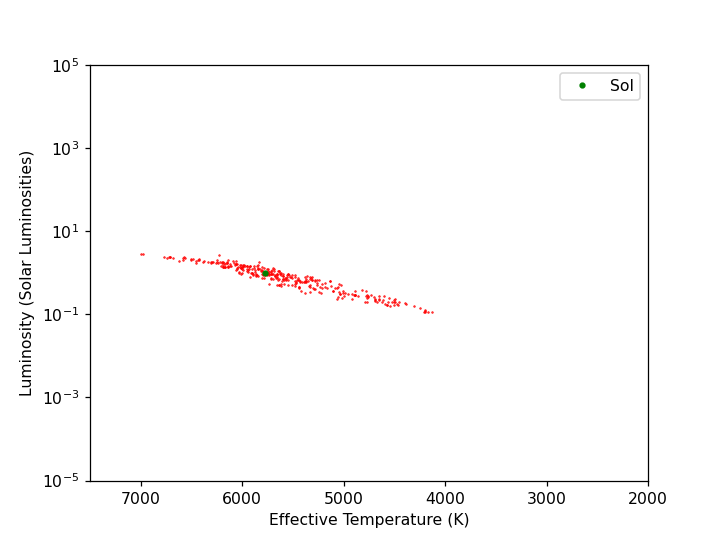

In [8]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
All_stars_directory = f'{Main_directory}/Sorted Data/Stars'
All_planets_directory = f'{Main_directory}/Sorted Data/Planets'

star_filenames = ['Gaia All Stars', 'Exo All Stars', 'Fulton All Stars', 'VanEylen All Stars', 'BASTA All Stars']
planet_filenames = ['VanHo All Planets', 'Fulton All Planets', 'VanEylen All Planets']

starframes = Create_dataframes(star_filenames, All_stars_directory, 'Gaia DR3 ID')
planetframes = Create_dataframes(planet_filenames, All_planets_directory, 'Host Gaia DR3 ID')

Gaia_teff = starframes['Gaia All Stars']['Teff']
Gaia_rad = starframes['BASTA All Stars']['Radius']

total_data = [Gaia_teff, Gaia_rad]
rejects = Ensure_all(total_data)
Remove_rejects(total_data, rejects)

Luminosity = Gaia_rad**2*(Gaia_teff/5772)**4

plt.figure()
plt.plot(Gaia_teff, Luminosity, 'r.', markersize=1)
plt.plot(5772, 1, 'g.', label='Sol')
plt.ylabel('Luminosity (Solar Luminosities)')
plt.xlabel('Effective Temperature (K)')
plt.xlim(2000, 7500)
plt.ylim(0.00001, 100000)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [5]:
Array = Get_filtered_arrays(All_stars_data, Filtered_headers)
Teff = Array[:,0]
Rad = Array[:,1]
Luminosity = Rad**2*(Teff/5772)**4

plt.figure()
plt.plot(Teff, Luminosity, 'r.', markersize=1)
plt.plot(5772, 1, 'g.', label='Sol')
plt.ylabel('Luminosity (Solar Luminosities)')
plt.xlabel('Effective Temperature (K)')
plt.xlim(2000, 7500)
plt.ylim(0.00001, 100000)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

sns.set_theme(style="ticks")

sns.jointplot(x=Teff, y=Luminosity, xlim=(7000, 3000), ylim=(-1, 7.5), kind="hex", color="#4CB391")

NameError: name 'Get_filtered_arrays' is not defined

In [ ]:
PSR_headers = ['PSR (VanHo)', 'PSR (Fulton)', 'PSR (Van Eylen)']
PSR_check = Data_check(All_planets_data, PSR_headers)

print(All_planets_data['Host Gaia ID'])
Planet_data = []
for P_index, IDp in enumerate(All_planets_data['Host Gaia ID']):
    for S_index, IDs in enumerate(All_stars_data['designation']):
        print([IDp, IDs])
        if IDp == IDs:
            P_radius = All_planets_data['PSR (VanHo)'][P_index]*All_stars_data['Radius (Gaia)'][S_index]
            P_period = All_planets_data['P (VanHo)'][P_index]
            Planet_data.append([P_radius, P_period])
            
print(Planet_data)